This notebook generates bounding boxes for each of the classes. The class information is provided in polygon form in `train_wkt_v4.csv` and is scaled according to the image sizes `60##_#_#_{}.tiff` and grid sizes in `grid_sizes.csv`.  It produces both a `.npz` containing a dict of dict of bboxes for each image. It will then also write these to an appropriate form for the DL algorithm of our choice, currently Faster R-CNN. The XML format is copied from there. Also produces `.txt` files indicating which images belong to which dataset (train, val, test).

If you intend to reproduce this, you might want to attach 'my' external volume to your AWS session.

First import the necessary modules and set the global variables N_CLASSES, BAND and MASK_SIZES.

In [8]:
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
import itertools
csv.field_size_limit(sys.maxsize)
import h5py
import os

import helper # this module contains some function that are used by a few of the notebooks on this matter

N_VAL = 5
N_CLASSES = 10
BAND = 'RGB' # which band to use
MASK_SIZES = {'A': 128, 'M': 800, 'P': 3*1024, 'RGB': 1024} # size of the Mask ARRAY to use
DEPTHS = {'A': 8, 'M': 8, 'P': 1, 'RGB': 3}
data_dir = '/data/dstl'
if BAND == 'RGB':
    dir_name = os.path.join(data_dir, 'three_band')
else:
    dir_name =  os.path.join(data_dir, 'sixteen_band')

Now define and run a function that fetches the size of each image and the scaler (x and y dir) required for scaling the polygons to the correct shape.

In [30]:
def create_sizes_and_scalers():
    im_sizes = {}
    scalers = {}
    
    for im_id in helper.image_iterator():
        masks_per_im = []
        im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format(im_id, BAND)))
        im_size = im.shape[-2::] # last two, regardless of whether there are three dims or not
        im_sizes[im_id] = im_size

    with open(os.path.join(data_dir, 'grid_sizes.csv')) as inf:
        reader = csv.reader(inf)
        next(reader)
        for im_id, x, y in reader:
            print im_id
            scaler = np.array(im_sizes[im_id])
            scaler = scaler * scaler.astype(float) / (scaler + 1)
            scalers[im_id] = (scaler[1]/float(x), scaler[0]/float(y))
    return im_sizes, scalers

im_sizes, scalers = create_sizes_and_scalers()

6120_2_4
6120_2_3
6120_2_2
6120_2_1
6120_2_0
6180_2_4
6180_2_1
6180_2_0
6180_2_3
6180_2_2
6180_0_3
6180_0_2
6180_0_1
6180_0_0
6180_0_4
6080_4_4
6080_4_2
6080_4_3
6080_4_0
6080_4_1
6090_4_1
6090_4_0
6090_4_3
6090_4_2
6090_4_4
6180_4_4
6180_4_3
6180_4_2
6180_4_1
6180_4_0
6160_3_2
6160_3_3
6160_3_0
6160_3_1
6160_3_4
6080_2_4
6080_2_0
6080_2_1
6080_2_2
6080_2_3
6080_0_2
6080_0_3
6080_0_0
6080_0_1
6080_0_4
6010_0_4
6010_0_1
6010_0_0
6010_0_3
6010_0_2
6010_2_3
6010_2_2
6010_2_1
6010_2_0
6010_2_4
6010_4_1
6170_3_4
6010_4_3
6010_4_2
6170_3_1
6170_3_0
6170_3_3
6170_3_2
6170_1_3
6170_1_2
6170_1_1
6170_1_0
6170_1_4
6130_4_2
6130_4_3
6130_4_0
6130_4_1
6130_4_4
6150_3_3
6150_3_2
6150_3_1
6150_3_0
6150_3_4
6130_2_0
6130_2_1
6130_2_2
6130_2_3
6130_2_4
6130_0_4
6130_0_2
6130_0_3
6130_0_0
6130_0_1
6150_1_4
6150_1_1
6150_1_0
6150_1_3
6150_1_2
6180_3_4
6180_3_0
6180_3_1
6180_3_2
6180_3_3
6180_1_2
6180_1_3
6180_1_0
6180_1_1
6180_1_4
6010_1_4
6010_1_0
6010_1_1
6010_1_2
6010_1_3
6010_3_2
6010_3_3
6010_3_0
6

Fill the masks with binary pixels indicating whether the pixel is in a certain class or not. We only create a dict entry for images that contain any class data. 

In [12]:
def create_bboxes(im_sizes, scalers):
    bboxes = {}

    with open(os.path.join(data_dir, 'train_wkt_v4.csv')) as inf:
        train = csv.reader(inf)
        next(train) # skip the header row
        for row_i, (im_id, poly_type, wktpoly) in enumerate(train):
            poly_type = int(poly_type) - 1
            int_coords = lambda x: np.array(x).round().astype(np.int32)
            polygons = shapely.wkt.loads(wktpoly)
            x_scaler, y_scaler = scalers[im_id]
            polygons = shapely.affinity.scale(polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

            if polygons:
                exteriors = [int_coords(poly.exterior.coords) for poly in polygons]

                # create masks for this image if they do not yet exist
                if not im_id in bboxes:
                    bboxes[im_id] = {}
                    for c in range(N_CLASSES):
                        bboxes[im_id][c] = []

                for exterior in exteriors:
                    x0 = exterior[:, 0].min()
                    x1 = exterior[:, 0].max()
                    y0 = exterior[:, 1].min()
                    y1 = exterior[:, 1].max()

                    # store bbox in both representations for what is necessary
                    bbox = {'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 
                            'x': (x0+x1)/2, 'y': (y0+y1)/2, 'w': (x1-x0), 'h': (y1-y0)}
                    bboxes[im_id][poly_type].append(bbox)
                print im_id, poly_type, len(bboxes[im_id][poly_type])
         
                # some output to keep track of the progress
    print 'Completed'
    return bboxes

bboxes = create_bboxes(im_sizes, scalers)

6040_2_2 3 2
6040_2_2 4 3879
6120_2_2 0 1962
6120_2_2 1 3201
6120_2_2 2 1
6120_2_2 3 33
6120_2_2 4 1452
6120_2_2 5 20
6120_2_2 7 6
6120_2_2 8 9
6120_2_2 9 548
6120_2_0 0 573
6120_2_0 1 1193
6120_2_0 2 1
6120_2_0 3 4
6120_2_0 4 1542
6120_2_0 5 67
6120_2_0 8 6
6120_2_0 9 11
6090_2_0 1 11
6090_2_0 3 3
6090_2_0 4 2308
6090_2_0 5 7
6090_2_0 7 19
6090_2_0 9 1
6040_1_3 3 1
6040_1_3 4 3982
6040_1_3 5 2
6040_1_0 3 5
6040_1_0 4 2446
6100_1_3 0 2208
6100_1_3 1 1581
6100_1_3 2 1
6100_1_3 3 13
6100_1_3 4 823
6100_1_3 5 3
6100_1_3 7 4
6100_1_3 8 11
6100_1_3 9 129
6010_4_2 3 6
6010_4_2 4 2262
6110_4_0 0 437
6110_4_0 1 502
6110_4_0 2 2
6110_4_0 3 11
6110_4_0 4 1406
6110_4_0 5 29
6110_4_0 7 24
6110_4_0 8 7
6110_4_0 9 13
6140_3_1 0 565
6140_3_1 1 563
6140_3_1 2 1
6140_3_1 3 19
6140_3_1 4 1110
6140_3_1 5 37
6140_3_1 7 9
6140_3_1 8 3
6140_3_1 9 46
6110_1_2 0 1584
6110_1_2 1 1420
6110_1_2 2 1
6110_1_2 3 10
6110_1_2 4 855
6110_1_2 5 28
6110_1_2 7 63
6110_1_2 9 23
6100_2_3 0 1690
6100_2_3 1 1226
6100_2_3 2 2

Save the result to bboxes_{}.npz

In [68]:
np.savez(os.path.join(data_dir, 'bboxes_{}.npz'.format(BAND)), bboxes=bboxes, im_sizes=im_sizes)

Load the data from the drive (only if not already in memory)

In [13]:
bboxes = np.load(os.path.join(data_dir, 'bboxes_{}.npz'.format(BAND)))['bboxes'][()]

Loop over all images, but tell iterator to only produce ids that have masks.
Note that this could also be done via a loop over the masks, but we previously also included empty data, and might wish to so again in the future

In [21]:
id_val = []
id_trn = []
id_tst = []
for i, im_id in enumerate(helper.image_iterator(bboxes.keys())):
    pass
N_tot = i
N_lbl = len(bboxes)
np.random.seed(21)
choice = np.sort(np.random.choice(range(N_lbl), N_VAL, replace=False))

i = 0
for im_id in helper.image_iterator():
    if im_id in bboxes:
        if i in choice:
            id_val.append(im_id)
        else:
            id_trn.append(im_id)
        i = i + 1
    else:
        id_tst.append(im_id)

In [22]:
list_dir = os.path.join(dir_name, 'ImageSets', 'Main')
with open(os.path.join(list_dir,'train.txt'), 'w') as f_trn, \
     open(os.path.join(list_dir, 'val.txt'), 'w') as f_val, \
     open(os.path.join(list_dir, 'trainval.txt'), 'w') as f_trnval, \
     open(os.path.join(list_dir, 'test.txt'), 'w') as f_tst:
    for im_id in id_val:
        f_val.write('{:s}_{:s}\n'.format(im_id, BAND))
        f_trnval.write('{:s}_{:s}\n'.format(im_id, BAND))
    for im_id in id_trn:
        f_trn.write('{:s}_{:s}\n'.format(im_id, BAND))
        f_trnval.write('{:s}_{:s}\n'.format(im_id, BAND))
    for im_id in id_tst:
        f_tst.write('{:s}_{:s}\n'.format(im_id, BAND))
            

With all the work done, let us inspect some of the results

In [23]:
def show(img, interpolation='none', ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(img, interpolation='none', **kwargs)
    return ax
    
def draw_rectangle(bbox, ax=None):
    x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
    x_v = np.array([-.5,  .5, .5, -.5, -.5])
    y_v = np.array([-.5, -.5, .5,  .5, -.5])
    ax.plot(x + w*x_v, y + h*y_v, '-')

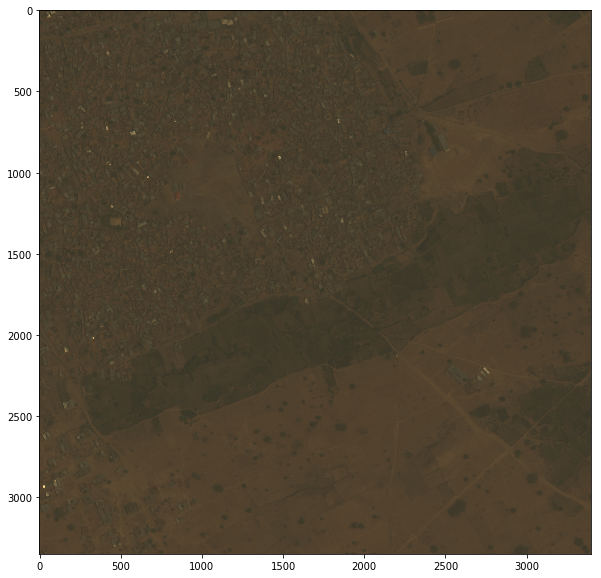

In [25]:
i_val = 4
im_id = id_val[i_val] # Let's look at the first image in the validation set
im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format( im_id, BAND)))
# im = im.transpose([1, 2, 0]).astype(float)/(8*255)
im = (im.transpose([1, 2, 0])/8).astype(np.uint8)
show(im)


1607


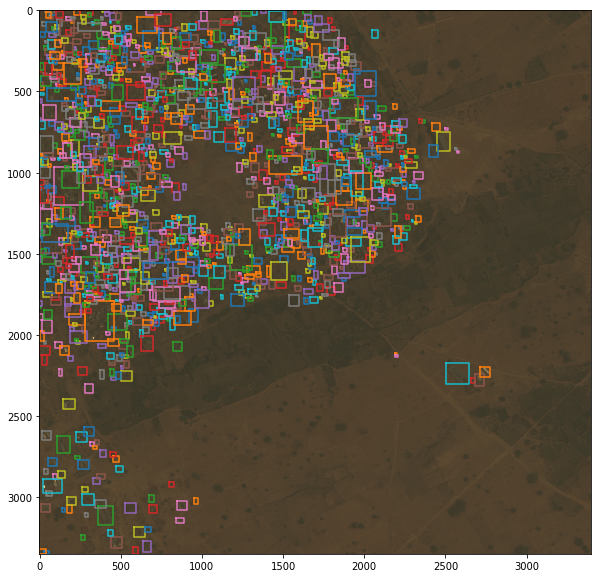

In [26]:
c = 0# class
im_annotate = im.copy()
print len(bboxes[im_id][c])
ax = show(im_annotate)
for i, bbox in enumerate(bboxes[im_id][c]):
    x, y, w, h = bbox['x'], bbox['y'], bbox['w'], bbox['h']
    draw_rectangle(bbox, ax)

In [27]:
if 'masks' not in globals():
    masks = np.load(os.path.join(data_dir, 'masks_{}.npz'.format(BAND)))['masks'][()]

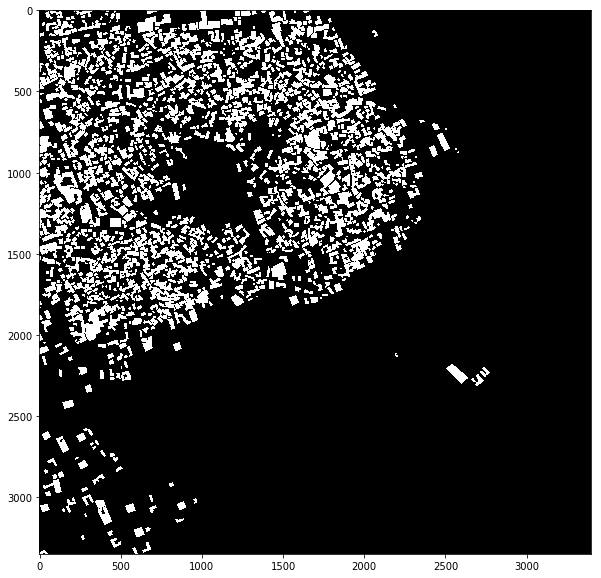

In [28]:
show(masks[im_id][c], cmap='gray')

The loop below shows four images per row, one for each class: the bare image, the image overlaid with bounding boxes, the masks from the `mask` dictionary and the masks from the `y_val` tensor.

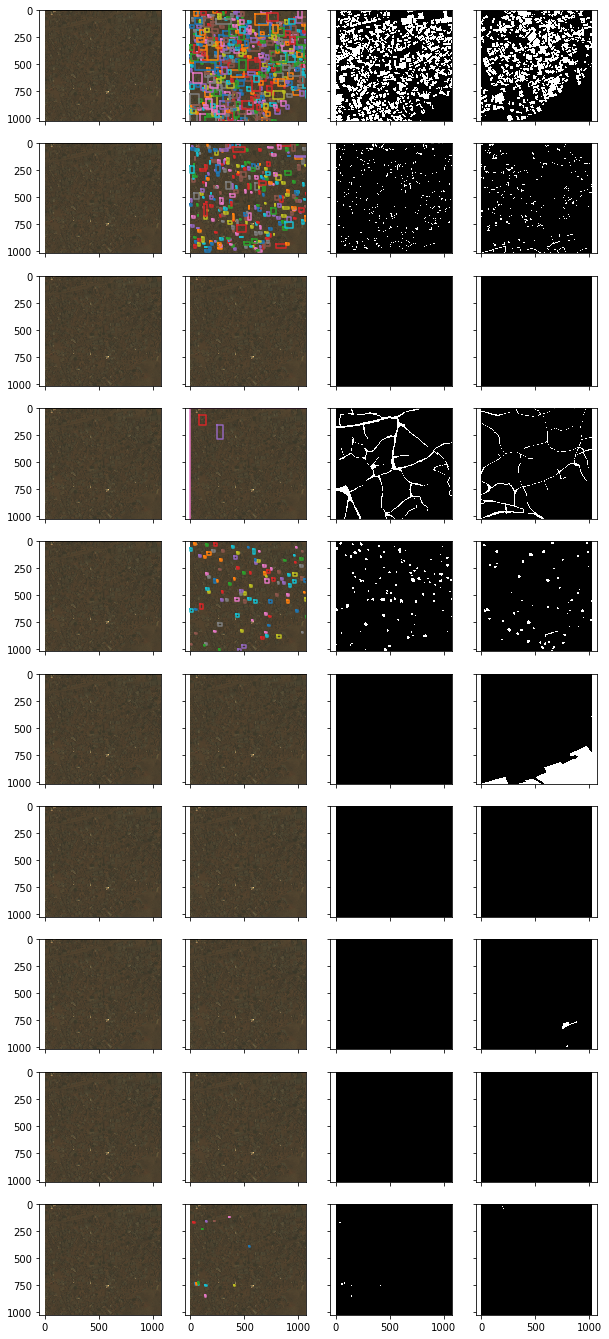

In [31]:
fig, axs = plt.subplots(10, 4, sharex=True, sharey=True)
fig.set_size_inches(10, 24)

im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format(im_id, BAND)))
im = (im.transpose([1, 2, 0])/8).astype(np.uint8)

X_val, y_val, X_trn, y_trn = helper.get_more_patches(BAND, 1024, repetitions=1, classes=range(10))

for c in range(10):
    im_annotate = im.copy()
    show(im, ax=axs[c, 0])
    show(im_annotate, cmap='gray', ax=axs[c, 1])
    for i, bbox in enumerate(bboxes[im_id][c]):
        draw_rectangle(bbox, ax=axs[c, 1])
    show(masks[im_id][c], cmap='gray', ax=axs[c, 2])
    show(y_val[i_val, c], cmap='gray', ax=axs[c, 3])

In [62]:
print y_val.shape

(5, 10, 1024, 1024)
